# 基于位置方差的机器人运动学参数校准测试

目标函数:最小化观测点位置方差
目标精度:位置标准差1mm以内

In [1]:
import torch
import numpy as np
from main_cali.DHRobotWithBeta_torch import DHRobotWithBeta, RevoluteDHWithBeta
from main_cali.calibrator import RobotCalibrator

# 设置随机种子以确保结果可复现
torch.manual_seed(43)
np.random.seed(43)

print("=== Position Variance-Based Robot Kinematics Parameter Calibration Demo ===")
print("Objective Function: Minimize variance of observed positions")
print("Target precision: Position standard deviation < 1 mm")

=== Position Variance-Based Robot Kinematics Parameter Calibration Demo ===
Objective Function: Minimize variance of observed positions
Target precision: Position standard deviation < 1 mm


## 1. 创建机器人模型

In [2]:
def create_simple_robot() -> DHRobotWithBeta:
    """
    创建一个真实的6自由度机器人用于测试(包含base和可校准的手眼参数)
    
    :return: 机器人模型
    """
    import numpy as np
    
    # 1. 定义理想的机器人参数(未添加偏差)
    ideal_hand_eye_params = [50, 20, 10, 0.1, 0.2, 0.3] 
    ideal_base_params = [100, 50, 0, 0.05, 0.1, 0]

    ideal_joint_params = [
        {'a': 0.0,      'd': 236.3,   'theta': 0.0,  'alpha': np.pi/2,   'beta': 0.0},  # Joint 1: a=0.0m, d=0.2363m, alpha=π/2
        {'a': -862.0,   'd': 0.0,     'theta': 0.0,  'alpha': 0.0,       'beta': 0.0},  # Joint 2: a=-0.8620m, d=0.0m, alpha=0
        {'a': -728.7,   'd': 0.0,     'theta': 0.0,  'alpha': 0.0,       'beta': 0.0},  # Joint 3: a=-0.7287m, d=0.0m, alpha=0
        {'a': 0.0,      'd': 201.0,   'theta': 0.0,  'alpha': np.pi/2,   'beta': 0.0},  # Joint 4: a=0.0m, d=0.2010m, alpha=π/2
        {'a': 0.0,      'd': 159.3,   'theta': 0.0,  'alpha': -np.pi/2,  'beta': 0.0},  # Joint 5: a=0.0m, d=0.1593m, alpha=-π/2
        {'a': 0.0,      'd': 154.3,   'theta': 0.0,  'alpha': 0.0,       'beta': 0.0},  # Joint 6: a=0.0m, d=0.1543m, alpha=0
    ]
    
    # 2. 定义base变换矩阵 (从世界坐标系到机器人基坐标系)
    # ideal_base_params = [tx, ty, tz, rx, ry, rz]
    base_translation = np.array([ideal_base_params[0], ideal_base_params[1], ideal_base_params[2]])  
    base_rotation = np.array([ideal_base_params[3], ideal_base_params[4], ideal_base_params[5]])  # 弧度
    
    # 创建base变换矩阵
    def euler_to_rotation_matrix(rx, ry, rz):
        """将欧拉角转换为旋转矩阵"""
        Rx = np.array([[1, 0, 0],
                       [0, np.cos(rx), -np.sin(rx)],
                       [0, np.sin(rx), np.cos(rx)]])
        
        Ry = np.array([[np.cos(ry), 0, np.sin(ry)],
                       [0, 1, 0],
                       [-np.sin(ry), 0, np.cos(ry)]])
        
        Rz = np.array([[np.cos(rz), -np.sin(rz), 0],
                       [np.sin(rz), np.cos(rz), 0],
                       [0, 0, 1]])
        
        return Rz @ Ry @ Rx
    
    base_rotation_matrix = euler_to_rotation_matrix(base_rotation[0], base_rotation[1], base_rotation[2])
    base_transform = np.eye(4)
    base_transform[0:3, 0:3] = base_rotation_matrix
    base_transform[0:3, 3] = base_translation
    
    # 3. 创建连杆列表
    links = []
    
    # 根据理想参数创建6个连杆
    for i, params in enumerate(ideal_joint_params):
        link = RevoluteDHWithBeta(
            a=params['a'],           # 连杆长度
            d=params['d'],           # 连杆偏移
            alpha=params['alpha'],   # 连杆扭角
            beta=params['beta'],     # 连杆扭角修正
            offset=params['theta'],  # 关节偏移角度(theta)
            name=f"link{i+1}"
        )
        links.append(link)
    
    # 4. 创建机器人(不传入tool变换,使其使用可校准的手眼参数)
    robot = DHRobotWithBeta(
        links, 
        name="Real_6DOF_Robot",
        base=torch.tensor(base_transform, dtype=torch.float64)
        # 注意:不传入tool参数,让robot使用可校准的手眼参数
    )
    
    # 5. 设置理想的手眼参数作为初始值
    robot.tx = ideal_hand_eye_params[0]
    robot.ty = ideal_hand_eye_params[1] 
    robot.tz = ideal_hand_eye_params[2]
    robot.rx = ideal_hand_eye_params[3]
    robot.ry = ideal_hand_eye_params[4]
    robot.rz = ideal_hand_eye_params[5]
    
    return robot

# 创建机器人
robot = create_simple_robot()
print(f"Created robot: {robot.name}")
print(f"Robot DOF: {robot.n}")

# 打印机器人参数
print("\nRobot DH Parameters:")
for i, link in enumerate(robot.links):
    print(f"Link {i+1}: a={link.a.item():.1f}mm, d={link.d.item():.1f}mm, "
          f"alpha={np.degrees(link.alpha.item()):.1f}°, beta={np.degrees(link.beta.item()):.1f}°, "
          f"theta_offset={np.degrees(link.offset.item()):.1f}°")

# 打印base变换
print("\nBase Transform (World to Robot Base):")
if hasattr(robot, 'base') and robot.base is not None:
    base_pos = robot.base[0:3, 3]
    print(f"  Translation: x={base_pos[0]:.1f}mm, y={base_pos[1]:.1f}mm, z={base_pos[2]:.1f}mm")
    print(f"  Base transform shape: {robot.base.shape}")
else:
    print("  No base transform defined")

# 打印手眼参数(现在是可校准的)
print("\nHand-Eye Parameters (Calibratable):")
print(f"  Translation: tx={robot.tx.item():.1f}mm, ty={robot.ty.item():.1f}mm, tz={robot.tz.item():.1f}mm")
print(f"  Rotation: rx={robot.rx.item():.3f}rad, ry={robot.ry.item():.3f}rad, rz={robot.rz.item():.3f}rad")
print(f"  Tool transform shape: {robot.tool.shape}")

# 测试前向运动学
q_test = [0.1, 0.2, 0.3, 0.1, 0.2, 0.1]  # 6个关节角度
print(f"\nTest joint angles: {q_test}")
T_test = robot.fkine(q_test)
print(f"Forward kinematics test passed")
print(f"End effector position: {T_test[0:3, 3].detach().numpy()}")
print(f"End effector position (mm): {T_test[0:3, 3].detach().numpy()}")

Created robot: Real_6DOF_Robot
Robot DOF: 6

Robot DH Parameters:
Link 1: a=0.0mm, d=236.3mm, alpha=90.0°, beta=0.0°, theta_offset=0.0°
Link 2: a=-862.0mm, d=0.0mm, alpha=0.0°, beta=0.0°, theta_offset=0.0°
Link 3: a=-728.7mm, d=0.0mm, alpha=0.0°, beta=0.0°, theta_offset=0.0°
Link 4: a=0.0mm, d=201.0mm, alpha=90.0°, beta=0.0°, theta_offset=0.0°
Link 5: a=0.0mm, d=159.3mm, alpha=-90.0°, beta=0.0°, theta_offset=0.0°
Link 6: a=0.0mm, d=154.3mm, alpha=0.0°, beta=0.0°, theta_offset=0.0°

Base Transform (World to Robot Base):
  Translation: x=100.0mm, y=50.0mm, z=0.0mm
  Base transform shape: torch.Size([4, 4])

Hand-Eye Parameters (Calibratable):
  Translation: tx=50.0mm, ty=20.0mm, tz=10.0mm
  Rotation: rx=0.100rad, ry=0.200rad, rz=0.300rad
  Tool transform shape: torch.Size([4, 4])

Test joint angles: [0.1, 0.2, 0.3, 0.1, 0.2, 0.1]
Forward kinematics test passed
End effector position: [-1287.05939768  -439.10612873  -275.10654886]
End effector position (mm): [-1287.05939768  -439.10612873 

## 2. 创建校准器

In [3]:
# 创建高精度校准器,使用新的排除规则
calibrator = RobotCalibrator(
    robot, 
    calibration_params=['a', 'alpha', 'd', 'beta', 'offset', 'tx', 'ty', 'tz', 'rx', 'ry', 'rz'], 
    excluded_params={
        0: ['d','beta'],           # 排除第一关节(索引0)的d和beta参数
        1: ['d'],                   # 排除第二关节(索引1)的d参数  
        2: ['d'],                   # 排除第三关节(索引2)的d参数
        3: ['d','beta'],           # 排除第四关节(索引3)的d和beta参数
        4: ['beta'],               # 排除第五关节(索引4)的beta参数
        5: ['beta']                # 排除第六关节(索引5)的beta参数
    },
    target_precision=1e-8
)
print(f"Created high-precision calibrator")
print(f"Calibration parameters: {calibrator.calibration_params}")
print(f"Target precision (variance): {calibrator.target_precision:.2e}")
print("Excluded parameters:")
print("  Joint 0 (Link 1): d, beta")
print("  Joint 1 (Link 2): d") 
print("  Joint 2 (Link 3): d")
print("  Joint 3 (Link 4): d, beta")
print("  Joint 4 (Link 5): beta")
print("  Joint 5 (Link 6): beta")
print("Note: Hand-eye parameters (tx, ty, tz, rx, ry, rz) included for calibration")

Created high-precision calibrator
Calibration parameters: ['a', 'alpha', 'd', 'beta', 'offset', 'tx', 'ty', 'tz', 'rx', 'ry', 'rz']
Target precision (variance): 1.00e-08
Excluded parameters:
  Joint 0 (Link 1): d, beta
  Joint 1 (Link 2): d
  Joint 2 (Link 3): d
  Joint 3 (Link 4): d, beta
  Joint 4 (Link 5): beta
  Joint 5 (Link 6): beta
Note: Hand-eye parameters (tx, ty, tz, rx, ry, rz) included for calibration


## 3. 添加参数偏差

In [4]:
# 添加参数偏差来模拟真实情况
print("Adding parameter deviations...")

# 保存原始参数
original_params = []
for i, link in enumerate(robot.links):
    original_params.append({
        'a': link.a.item(),
        'alpha': link.alpha.item(),
        'd': link.d.item(),
        'beta': link.beta.item(),
        'theta': link.offset.item()  # 添加theta参数
    })

# 保存原始base变换和手眼参数
original_base = robot.base.clone() if hasattr(robot, 'base') and robot.base is not None else None
original_hand_eye = {
    'tx': robot.tx.item(),
    'ty': robot.ty.item(), 
    'tz': robot.tz.item(),
    'rx': robot.rx.item(),
    'ry': robot.ry.item(),
    'rz': robot.rz.item()
}

# 定义关节参数偏差(模拟制造误差和安装误差) - 6个关节
deviations = [
    {'a': 4, 'alpha': 0.01, 'd': 0, 'beta': 0.0, 'theta': 0.00},    # Link 1
    {'a': 6, 'alpha': 0.015, 'd': 0.0, 'beta': 0.0008, 'theta': 0.0015},  # Link 2
    {'a': 3, 'alpha': 0.08, 'd': 0.0, 'beta': 0.0006, 'theta': 0.001},   # Link 3
    {'a': 8, 'alpha': 0.012, 'd': 0, 'beta': 0.0000, 'theta': 0.0025},  # Link 4
    {'a': 5, 'alpha': 0.06, 'd': 4, 'beta': 0.00, 'theta': 0.0018},   # Link 5
    {'a': 2, 'alpha': 0.005, 'd': 3, 'beta': 0.0003, 'theta': 0.001}  # Link 6
]

# 定义手眼参数偏差
hand_eye_deviations = {
    'tx': 2.0,   # 2mm偏差
    'ty': 1.5,   # 1.5mm偏差
    'tz': 3.0,   # 3mm偏差
    'rx': 0.005, # 0.005rad偏差
    'ry': 0.008, # 0.008rad偏差
    'rz': 0.003  # 0.003rad偏差
}

# 创建偏差后的连杆
links = []
for i, (original, dev) in enumerate(zip(original_params, deviations)):
    link = RevoluteDHWithBeta(
        a=original['a'] + dev['a'],
        d=original['d'] + dev['d'],
        alpha=original['alpha'] + dev['alpha'],
        beta=original['beta'] + dev['beta'],
        offset=original['theta'] + dev['theta'],
        name=f"link{i+1}"
    )
    links.append(link)

# 应用偏差后的 base 变换
if original_base is not None:
    base_deviation = torch.tensor([
        [0.0, 0.0, 0.0, 3.0],  # x方向3mm偏差
        [0.0, 0.0, 0.0, 2.0],  # y方向2mm偏差
        [0.0, 0.0, 0.0, 1.0],  # z方向1mm偏差
        [0.0, 0.0, 0.0, 0.0]
    ], dtype=torch.float64)

    small_rotation = torch.tensor([
        [np.cos(0.005), -np.sin(0.005), 0.0, 0.0],
        [np.sin(0.005), np.cos(0.005), 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]
    ], dtype=torch.float64)

    base = original_base + base_deviation
    base = small_rotation @ base
else:
    base = torch.eye(4, dtype=torch.float64)

# 创建真实机器人模型(不传入tool,使用可校准的手眼参数)
real_robot = DHRobotWithBeta(links, name="Real_Robot_With_Deviations", base=original_base)

# 设置偏差后的手眼参数
real_robot.tx = original_hand_eye['tx'] + hand_eye_deviations['tx']
real_robot.ty = original_hand_eye['ty'] + hand_eye_deviations['ty']
real_robot.tz = original_hand_eye['tz'] + hand_eye_deviations['tz']
real_robot.rx = original_hand_eye['rx'] + hand_eye_deviations['rx']
real_robot.ry = original_hand_eye['ry'] + hand_eye_deviations['ry']
real_robot.rz = original_hand_eye['rz'] + hand_eye_deviations['rz']

# 打印生成的真实机器人信息
print(f"Created real robot: {real_robot.name}")
print(f"Robot DOF: {real_robot.n}")

# 打印偏差后的机器人参数
print("\nReal Robot DH Parameters:")
for i, link in enumerate(real_robot.links):
    print(f"Link {i+1}: a={link.a.item():.1f}mm, d={link.d.item():.1f}mm, "
          f"alpha={np.degrees(link.alpha.item()):.1f}°, beta={np.degrees(link.beta.item()):.1f}°, "
          f"theta_offset={np.degrees(link.offset.item()):.1f}°")

# 打印偏差后的 base 变换
print("\nBase Transform (World to Robot Base):")
if hasattr(real_robot, 'base') and real_robot.base is not None:
    base_pos = real_robot.base[0:3, 3]
    print(f"  Translation: x={base_pos[0]:.1f}mm, y={base_pos[1]:.1f}mm, z={base_pos[2]:.1f}mm")
    print(f"  Base transform shape: {real_robot.base.shape}")
else:
    print("  No base transform defined")

# 打印偏差后的手眼参数
print("\nHand-Eye Parameters (with deviations):")
print(f"  Translation: tx={real_robot.tx.item():.1f}mm, ty={real_robot.ty.item():.1f}mm, tz={real_robot.tz.item():.1f}mm")
print(f"  Rotation: rx={real_robot.rx.item():.3f}rad, ry={real_robot.ry.item():.3f}rad, rz={real_robot.rz.item():.3f}rad")

print("\nHand-Eye Parameter Deviations:")
for param_name, deviation in hand_eye_deviations.items():
    if param_name in ['tx', 'ty', 'tz']:
        print(f"  {param_name}: {deviation:+.1f}mm")
    else:
        print(f"  {param_name}: {deviation:+.3f}rad")

Adding parameter deviations...
Created real robot: Real_Robot_With_Deviations
Robot DOF: 6

Real Robot DH Parameters:
Link 1: a=4.0mm, d=236.3mm, alpha=90.6°, beta=0.0°, theta_offset=0.0°
Link 2: a=-856.0mm, d=0.0mm, alpha=0.9°, beta=0.0°, theta_offset=0.1°
Link 3: a=-725.7mm, d=0.0mm, alpha=4.6°, beta=0.0°, theta_offset=0.1°
Link 4: a=8.0mm, d=201.0mm, alpha=90.7°, beta=0.0°, theta_offset=0.1°
Link 5: a=5.0mm, d=163.3mm, alpha=-86.6°, beta=0.0°, theta_offset=0.1°
Link 6: a=2.0mm, d=157.3mm, alpha=0.3°, beta=0.0°, theta_offset=0.1°

Base Transform (World to Robot Base):
  Translation: x=100.0mm, y=50.0mm, z=0.0mm
  Base transform shape: torch.Size([4, 4])

Hand-Eye Parameters (with deviations):
  Translation: tx=52.0mm, ty=21.5mm, tz=13.0mm
  Rotation: rx=0.105rad, ry=0.208rad, rz=0.303rad

Hand-Eye Parameter Deviations:
  tx: +2.0mm
  ty: +1.5mm
  tz: +3.0mm
  rx: +0.005rad
  ry: +0.008rad
  rz: +0.003rad


## 4. 生成观测数据

In [5]:
from main_cali.data_generate import generate_sphere_point_cloud_data

# 生成基于球体的高精度测试数据
observations = generate_sphere_point_cloud_data(real_robot, num_samples=50, noise_std=0.01)  # 50个样本,0.01mm噪声

print(f"Generated {len(observations)} observations")
print(f"Measurement noise std: {0.01:.2f} mm")

# 显示一些样本的关节角度范围
sample_joints = [obs['joint_state'] for obs in observations[:5]]
print(f"\nSample joint angles (first 5):")
for i, joints in enumerate(sample_joints):
    joints_list = joints.tolist() if isinstance(joints, torch.Tensor) else joints
    print(f"  Sample {i+1}: {[f'{j:.3f}' for j in joints_list]}")

# 显示点云信息
print(f"\nPoint cloud info:")
print(f"  Points per observation: {len(observations[0]['point_cloud'])}")
print(f"  Point cloud shape: {observations[0]['point_cloud'].shape}")
    
calibrator.set_observations(observations)

Generating 50 high-precision sphere-based point cloud samples...
Generated 50 observations
Measurement noise std: 0.01 mm

Sample joint angles (first 5):
  Sample 1: ['0.828', '-0.828', '-1.981', '1.430', '3.021', '0.085']
  Sample 2: ['3.029', '0.578', '-1.314', '-2.698', '0.165', '-2.470']
  Sample 3: ['-0.029', '0.294', '2.740', '-0.480', '1.082', '-2.111']
  Sample 4: ['1.766', '2.030', '-0.264', '2.238', '0.602', '-0.233']
  Sample 5: ['2.150', '0.694', '1.310', '-2.270', '-2.047', '2.982']

Point cloud info:
  Points per observation: 100
  Point cloud shape: torch.Size([100, 3])
Loaded 50 observations with computed centers


Calculating end effector positions from observations...
Calculated 50 end effector positions


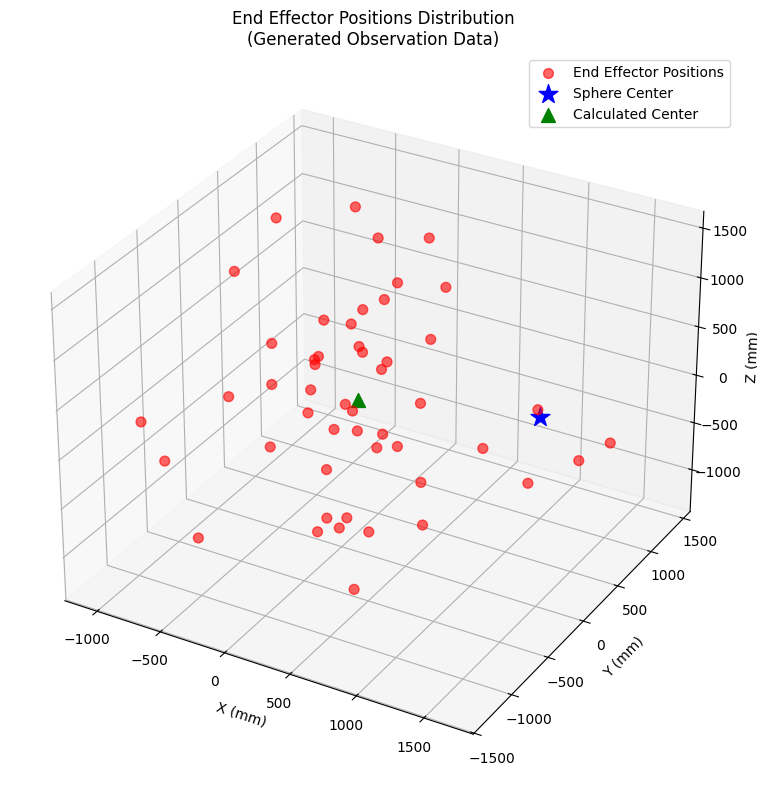


=== End Effector Position Statistics ===
Number of positions: 50
True sphere center: [1500.0, 0.0, 500.0] mm
Calculated center: [133.3, 0.8, 142.8] mm
Center error: 1412.61 mm
Mean radius: 1747.60 mm
Radius std dev: 495.20 mm
Position range:
  X: -1108.4 to 1710.2 mm
  Y: -1128.2 to 1219.6 mm
  Z: -1449.6 to 1667.1 mm


In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 计算所有观测点的末端位置
print("Calculating end effector positions from observations...")
end_positions = []
joint_positions = []

for obs in observations:  # observations 现在是列表，不是字典
    q = obs['joint_state']
    joint_positions.append(q)
    
    # 使用真实机器人计算末端位置
    T = real_robot.fkine(q)
    pos = T[0:3, 3].detach().numpy()
    end_positions.append(pos)

end_positions = np.array(end_positions)
# 球心位置（与data_generate.py中一致）
sphere_center = torch.tensor([1500, 0, 500], dtype=torch.float64).numpy()

print(f"Calculated {len(end_positions)} end effector positions")

# 创建3D可视化
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制末端位置点
ax.scatter(end_positions[:, 0], end_positions[:, 1], end_positions[:, 2], 
           c='red', alpha=0.6, s=50, label='End Effector Positions')

# 绘制球心
ax.scatter(sphere_center[0], sphere_center[1], sphere_center[2], 
           c='blue', s=200, marker='*', label='Sphere Center')

# 计算并显示位置统计
center_calc = np.mean(end_positions, axis=0)
distances = np.linalg.norm(end_positions - sphere_center, axis=1)
radius_mean = np.mean(distances)
radius_std = np.std(distances)

ax.scatter(center_calc[0], center_calc[1], center_calc[2], 
           c='green', s=100, marker='^', label='Calculated Center')

# 设置图形属性
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
ax.set_title('End Effector Positions Distribution\n(Generated Observation Data)')
ax.legend()

# 添加网格
ax.grid(True, alpha=0.3)

# 设置相等的坐标轴比例
max_range = np.array([end_positions[:,0].max()-end_positions[:,0].min(),
                      end_positions[:,1].max()-end_positions[:,1].min(),
                      end_positions[:,2].max()-end_positions[:,2].min()]).max() / 2.0
mid_x = (end_positions[:,0].max()+end_positions[:,0].min()) * 0.5
mid_y = (end_positions[:,1].max()+end_positions[:,1].min()) * 0.5
mid_z = (end_positions[:,2].max()+end_positions[:,2].min()) * 0.5

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.tight_layout()
plt.show()

# 打印统计信息
print(f"\n=== End Effector Position Statistics ===")
print(f"Number of positions: {len(end_positions)}")
print(f"True sphere center: [{sphere_center[0]:.1f}, {sphere_center[1]:.1f}, {sphere_center[2]:.1f}] mm")
print(f"Calculated center: [{center_calc[0]:.1f}, {center_calc[1]:.1f}, {center_calc[2]:.1f}] mm")
print(f"Center error: {np.linalg.norm(center_calc - sphere_center):.2f} mm")
print(f"Mean radius: {radius_mean:.2f} mm")
print(f"Radius std dev: {radius_std:.2f} mm")
print(f"Position range:")
print(f"  X: {end_positions[:,0].min():.1f} to {end_positions[:,0].max():.1f} mm")
print(f"  Y: {end_positions[:,1].min():.1f} to {end_positions[:,1].max():.1f} mm")
print(f"  Z: {end_positions[:,2].min():.1f} to {end_positions[:,2].max():.1f} mm")

## 5. 执行校准

In [ ]:
# 执行高精度校准 - 使用优化后的参数
print("\nStarting variance-based calibration...")
results = calibrator.calibrate(
    learning_rate=0.01,     # 降低学习率以适应方差优化
    max_iterations=10000,     # 调整迭代次数
    tolerance=1e-20,         # 更严格的收敛条件
    verbose=True
)


Starting variance-based calibration...
Initial Variance Error: 21410.879235
Target precision: 0.0000000100
Iteration 0: Variance Error = 21410.8792347196576884, LR = 0.010000000000

Calibration completed!
Initial Variance Error: 21410.879235
Final Variance Error: 5.5355440510871263
Target precision: 0.0000000100000000
Precision achieved: No
Error Improvement: 99.9741461152%


## 6. 显示校准结果

In [8]:
# 打印详细结果
print("\n=== High-Precision Calibration Results ===")
print(f"Converged: {'Yes' if results['converged'] else 'No'}")
print(f"Iterations: {results['iterations']}")
print(f"Target precision achieved: {'Yes' if results['precision_achieved'] else 'No'}")

if results['initial_variance_error'] > 0:
    improvement = ((results['initial_variance_error'] - results['final_variance_error']) / results['initial_variance_error'] * 100)
    print(f"Error Improvement: {improvement:.2f}%")

print("\nParameter Changes:")
for link_name in results['final_params']:
    if link_name != 'hand_eye':  # 跳过手眼参数,稍后单独处理
        print(f"\n{link_name}:")
        for param_name in results['final_params'][link_name]:
            initial = results['initial_params'][link_name][param_name]
            final = results['final_params'][link_name][param_name]
            change = final - initial
            if param_name in ['a', 'd']:
                print(f"  {param_name}: {initial:.6f} -> {final:.6f} (change: {change:+.6f} mm)")
            else:
                print(f"  {param_name}: {initial:.6f} -> {final:.6f} (change: {change:+.6f} rad)")

# 显示手眼参数变化
if 'hand_eye' in results['final_params']:
    print(f"\nhand_eye:")
    for param_name in results['final_params']['hand_eye']:
        initial = results['initial_params']['hand_eye'][param_name]
        final = results['final_params']['hand_eye'][param_name]
        change = final - initial
        if param_name in ['tx', 'ty', 'tz']:
            print(f"  {param_name}: {initial:.6f} -> {final:.6f} (change: {change:+.6f} mm)")
        else:
            print(f"  {param_name}: {initial:.6f} -> {final:.6f} (change: {change:+.6f} rad)")

# 提取real_robot参数进行对比
real_params = {}
for i, link in enumerate(real_robot.links):
    link_name = f"link_{i}"  # 修改为与results中一致的格式
    real_params[link_name] = {
        'a': link.a.item(),
        'alpha': link.alpha.item(),
        'd': link.d.item(),
        'beta': link.beta.item(),
        'offset': link.offset.item()
    }

# 添加真实机器人的手眼参数
real_params['hand_eye'] = {
    'tx': real_robot.tx.item(),
    'ty': real_robot.ty.item(),
    'tz': real_robot.tz.item(),
    'rx': real_robot.rx.item(),
    'ry': real_robot.ry.item(),
    'rz': real_robot.rz.item()
}

# 添加与真实机器人参数的对比
print("\n=== Comparison with Real Robot Parameters ===")
for link_name in results['final_params']:
    print(f"\n{link_name}:")
    final_params = results['final_params'][link_name]
    real_values = real_params[link_name]
    
    for param_name in final_params:
        calibrated_value = final_params[param_name]
        real_value = real_values[param_name]
        error = calibrated_value - real_value
        if param_name in ['a', 'd', 'tx', 'ty', 'tz']:
            print(f"  {param_name}: Real={real_value:.6f}, Calibrated={calibrated_value:.6f}, Error={error:+.6f} mm")
        else:
            print(f"  {param_name}: Real={real_value:.6f}, Calibrated={calibrated_value:.6f}, Error={error:+.6f} rad")


=== High-Precision Calibration Results ===
Converged: No
Iterations: 1000
Target precision achieved: No
Error Improvement: 99.97%

Parameter Changes:

link_0:
  a: 0.000000 -> 4.122848 (change: +4.122848 mm)
  alpha: 1.570796 -> 1.580851 (change: +0.010055 rad)
  d: 236.300000 -> 236.300000 (change: +0.000000 mm)
  beta: 0.000000 -> 0.000000 (change: +0.000000 rad)
  offset: 0.000000 -> 0.000000 (change: +0.000000 rad)

link_1:
  a: -862.000000 -> -856.267038 (change: +5.732962 mm)
  alpha: 0.000000 -> 0.014773 (change: +0.014773 rad)
  d: 0.000000 -> 0.000000 (change: +0.000000 mm)
  beta: 0.000000 -> 0.000730 (change: +0.000730 rad)
  offset: 0.000000 -> 0.000955 (change: +0.000955 rad)

link_2:
  a: -728.700000 -> -725.659267 (change: +3.040733 mm)
  alpha: 0.000000 -> 0.080021 (change: +0.080021 rad)
  d: 0.000000 -> 0.000000 (change: +0.000000 mm)
  beta: 0.000000 -> 0.000548 (change: +0.000548 rad)
  offset: 0.000000 -> 0.000302 (change: +0.000302 rad)

link_3:
  a: 0.000000 -> 

## 7. 可视化结果


Generating visualization...


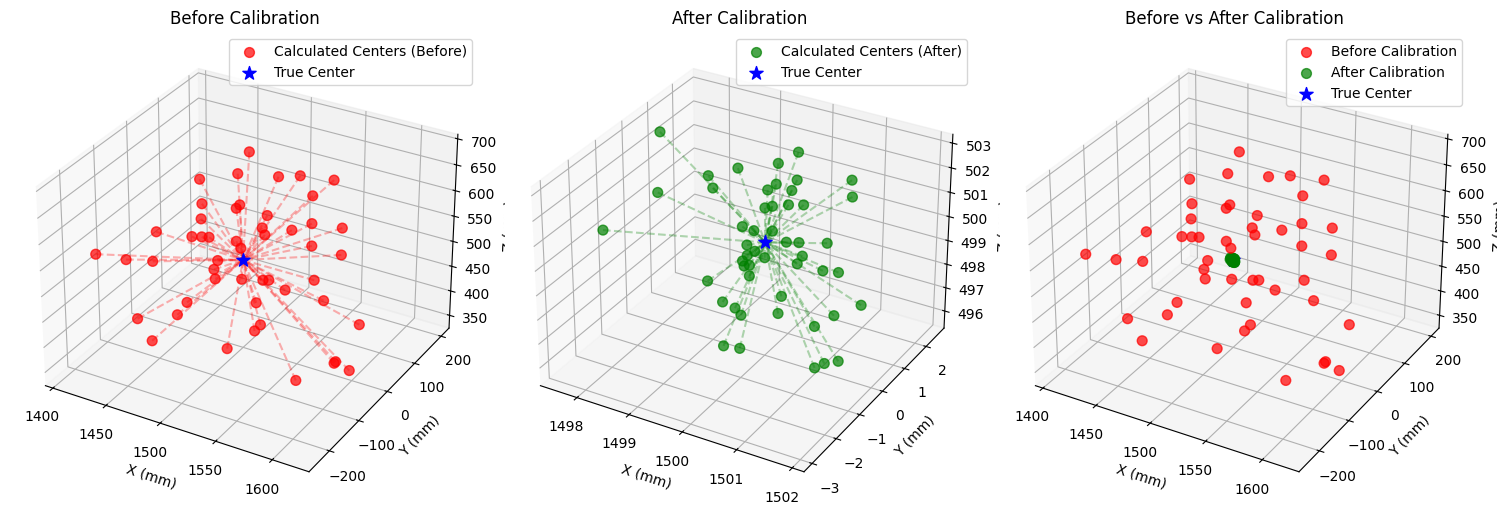


=== High-Precision Calibration Statistics ===
Before calibration:
  Mean error: 133.830 mm
  Std error: 55.875 mm
  Max error: 258.055 mm
  Min error: 36.043 mm

After calibration:
  Mean error: 2.13404516 mm
  Std error: 0.97823894 mm
  Max error: 4.52846527 mm
  Min error: 0.34726023 mm

Mean error improvement: 98.40540435%
Target precision (0.00000001mm): Not achieved
Points within target precision: 0/50 (0.0%)


In [9]:
from main_cali.data_anl import plot_calibration_results, plot_optimization_history

# 定义真实球心位置（与data_generate.py中一致）
true_sphere_center = [1500, 0, 500]  # 球心在基坐标系的位置 (mm)

# 绘制校准前后的结果
print("\nGenerating visualization...")
plot_calibration_results(results, true_sphere_center=true_sphere_center)

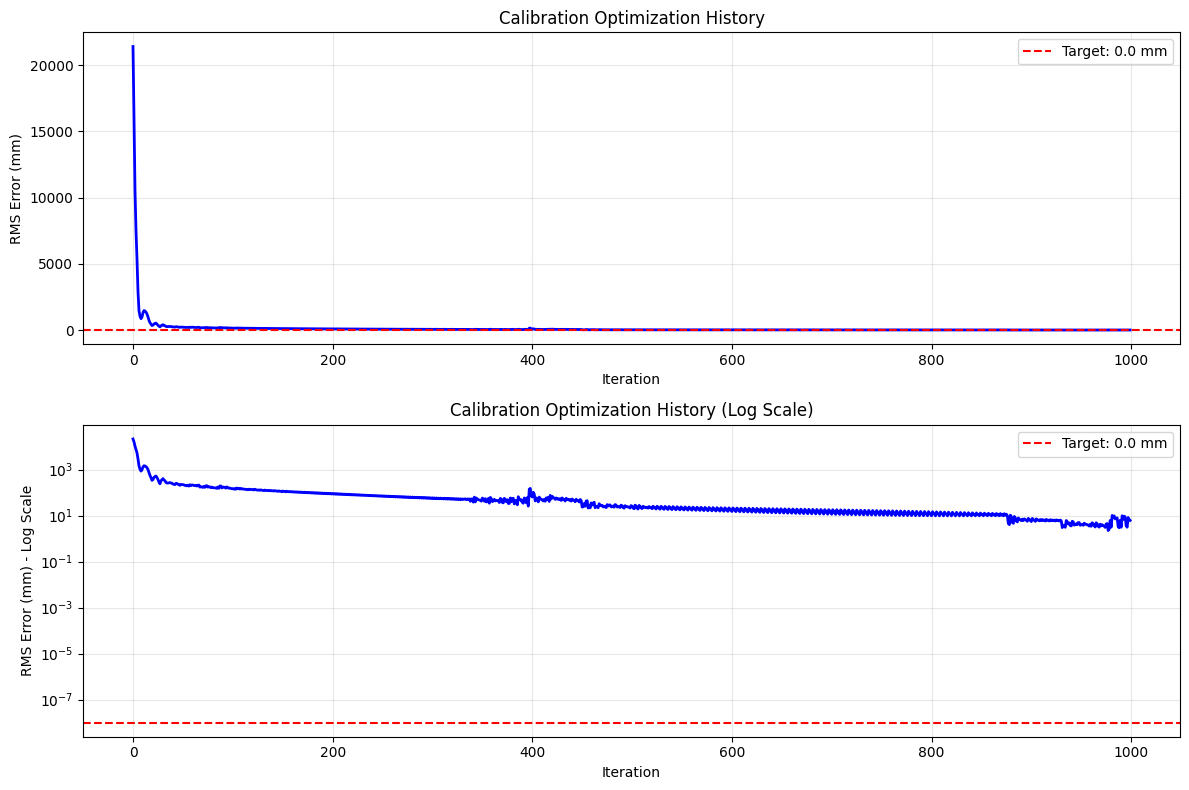

In [10]:
# 绘制优化历史
plot_optimization_history(results)

## 8. 结果分析

In [11]:
# 分析校准结果
print("\n=== Calibration Analysis ===")
print(f"Initial Variance Error: {results['initial_variance_error']:.6f}")
print(f"Final Variance Error: {results['final_variance_error']:.6f}")
print(f"Target Precision (variance): {results['target_precision']:.2e}")
print(f"Precision Achieved: {results['precision_achieved']}")

if results['precision_achieved']:
    print("\n✅ Successfully achieved variance precision target!")
else:
    print("\n❌ Failed to achieve variance precision target")
    print("Consider:")
    print("- Increasing number of samples")
    print("- Reducing measurement noise")
    print("- Adjusting optimization parameters")

# 计算位置标准差(方差的平方根)
import math
initial_std = math.sqrt(results['initial_variance_error'] / 3)  # 除以3是因为x,y,z三个维度
final_std = math.sqrt(results['final_variance_error'] / 3)

print(f"\n=== Position Standard Deviation Analysis ===")
print(f"Initial Position Std Dev: {initial_std:.3f} mm")
print(f"Final Position Std Dev: {final_std:.3f} mm")

if final_std < 1.0:
    print("✅ Position precision is better than 1mm (1σ)")
else:
    print("❌ Position precision is worse than 1mm (1σ)")


=== Calibration Analysis ===
Initial Variance Error: 21410.879235
Final Variance Error: 5.535544
Target Precision (variance): 1.00e-08
Precision Achieved: False

❌ Failed to achieve variance precision target
Consider:
- Increasing number of samples
- Reducing measurement noise
- Adjusting optimization parameters

=== Position Standard Deviation Analysis ===
Initial Position Std Dev: 84.481 mm
Final Position Std Dev: 1.358 mm
❌ Position precision is worse than 1mm (1σ)
